# Введение в обработку звука



### Баев Ален
### 18.05.2019

1. Что такое wav?
2. Как посмотреть звук и послушать картинку?
3. Учим нейронную сеть классифицировать аудио.

# Что такое wav?

### Данные

Это формат для хранения несжатого аудио сигнала. Основная информация представлена в виде одномерного массива из целых чисел (``data``).

Послушаем 10-секундный отрывок музыки

In [1]:
!file wav/music.wav

wav/music.wav: RIFF (little-endian) data, WAVE audio, Microsoft PCM, 16 bit, mono 44100 Hz


In [2]:
import librosa
from IPython.display import Audio

data, rate = librosa.load("wav/music.wav", sr=44100)
Audio(data=data, rate=rate)

Стандартное средство для отрисовки данных

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (15,3)


In [4]:
fig = plt.figure(1, figsize=(15, 3))

<Figure size 1080x216 with 0 Axes>

Звуковые волны - изменение давления. Можно считать, что в wav записаны отклонения мембраны от положения равновесия через равные промежутки времени.

<img src="img/speaker.png" alt="динамик" style="width: 200px;"/>

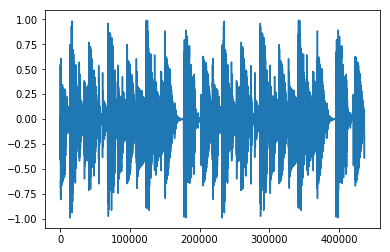

In [5]:
plt.plot(data);

### Параметр дискретизации

Время непрерывное, а сигнал фиксируется в дискретные моменты времени. Количество таких отсечек в теченне одной секунды называется частотой дискретизации (rate) и измеряется в Герцах.

Стандартное значение для аудио-книг 16 000 Гц, для музыки 44 100 Гц и более. Чем больше значение, тем более широкий диапазон частот можно закодировать.

Рассмотрим в более мелком масштабе (первую секунду).

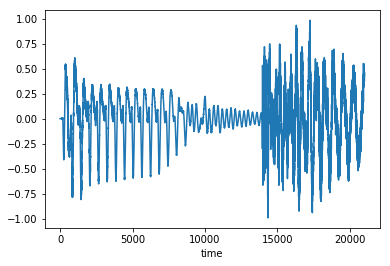

In [6]:
data_prefix = data[:21000]
plt.plot(data_prefix)
plt.xlabel("time")
Audio(data=data_prefix, rate=rate)

Давайте послушаем предыдущую запись с частотой 4 410 Гц. Для этого оставим только каждое 10 значение и изменим частоту дискретизации в 10 раза меньше.

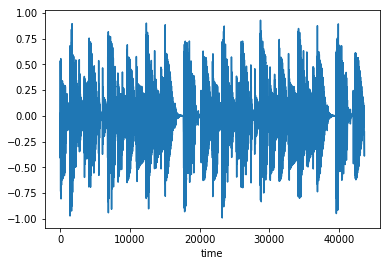

In [7]:
bad_data = data[::10]

plt.plot(bad_data)
plt.xlabel("time")
Audio(data=bad_data, rate=rate/10)

 Эффект "дискотеки у соседей".

### Генерируем простой звук

Вы давно слышали чистый синус? Небольшой генератор 
$$\sin(h \cdot 2 \pi x)$$


In [8]:
import numpy as np

def sinus(hz, duration, rate):
    size = int(duration * rate)
    s = np.zeros(size)
    for i in range(size):
        x = duration / size * i
        s[i] = np.sin(hz * 2 * np.pi * x)
    return s

Послушайте 2 секунды на частоте 200 Гц (200 колебаний в секунду)

$$sin(200 \cdot 2 \pi x)$$

Далее 2 секунды на частоте 250 Гц (300 колебаний в секунду)

$$sin(300 \cdot 2 \pi x)$$

В заключении 2 секунды вместе

$$sin(200 \cdot 2 \pi x) + sin(300 \cdot 2 \pi x)$$

In [9]:
rate = 44100
sec = 0.5
hz = [200]

sound_A = sinus(200, sec, rate)
sound_B = sinus(400, sec, rate)
sound = np.hstack([sound_A, sound_B])

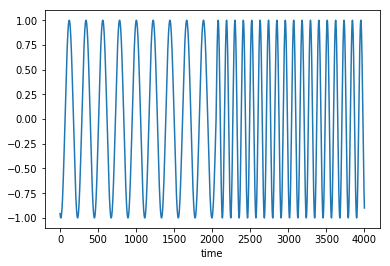

In [10]:
plt.plot(sound[20000:24000]);
plt.xlabel("time")

Audio(sound, rate=rate)

### Генерируем более сложный звук


А если взять несколько синусоид и сложить с разными коэффициентами?

In [11]:
size = 8
coefficient = [1, 8, 1, 6, 2, 3, 0, 7]
freq = [100, 200, 300, 400, 500, 600, 700, 800]

sounds = []
time = 1
for c, f in zip(coefficient, freq):
    oberton = c * sinus(f, time, rate)
    sounds.append(oberton)
sound = np.array(sounds).sum(axis=0)

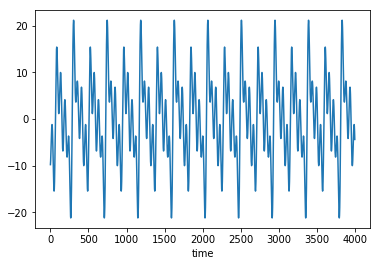

In [12]:
plt.plot(sound[20000:24000]);
plt.xlabel("time")

Audio(sound, rate=rate)

$$
1 \cdot \sin(100 \cdot 2 \pi x) + 
8 \cdot \sin(200 \cdot 2 \pi x) + 
1 \cdot \sin(300 \cdot 2 \pi x) +
6 \cdot \sin(400 \cdot 2 \pi x) + 
$$
$$
+
2 \cdot \sin(500 \cdot 2 \pi x) + 
3 \cdot \sin(600 \cdot 2 \pi x) + 
0 \cdot \sin(700 \cdot 2 \pi x) + 
7 \cdot \sin(800 \cdot 2 \pi x)
$$

Коэффициенты [1, 8, 1, 6, 2, 3, 0, 7] и называют коэффициентами Фурье!

## Вычисляем коэффициенты Фурье из сигнала

Волшебная непрерывная математика говорит, что из **непрерывного** на отрезке $[0, 1]$ сигнала 
$$
f(x) = \sum_{k = 1}^{+\infty} c_k \sin(2 \pi k x)
$$

можно определить коэффициенты Фурье абсолютно точно.

$$
c_k = \frac{2}{\pi} \int_{0}^{1} f(x) \sin(2 \pi k x) dx
$$

Волшебная дискретная математика говорит, что и из **дискретного** сигнала (массив чисел), который у нас есть:
$$
f_i = \sum_{k = 0}^{n-1} c_k \sin \left(2 \pi k \frac{i}{n}\right) 
$$
можно получить коэффициенты Фурье абсолютно точно
$$
c_k = \frac{1}{n} \sum_{i = 0}^{n-1} f_i \sin \left(2 \pi k \frac{i}{n}\right) 
$$

Коэффициенты $c_k$ имеет смысл громкости соответствующей синусоиды.

Например при количестве амплитуд $n$ и частоте дискретизации $rate = 16 000$ Гц $c_k$ соответствует громкости синусоиды на частоте
$$
\frac{k}{n} \cdot rate
$$

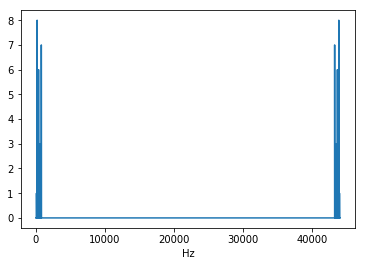

In [13]:
spectr = np.fft.fft(sound)
spectr = 2 * np.abs(spectr) / sound.size

plt.xlabel("Hz")
plt.plot(np.linspace(0, rate, spectr.size), spectr);

In [14]:
coefficient

[1, 8, 1, 6, 2, 3, 0, 7]

# Как посмотреть звук

### Оконное преобразование Фурье

Спектр всего сигнала не является информативным с точки зрения времени. В различные моменты времени звучит различные звуки, которые имеют свой спектр.

Сделаем оконное преобразование Фурье (Short-time Fourier transform). Например, будем анализировать блоки по $windows\_size = 1024$ отсечки сигнала. Начало следующего блока будет сдвинуто относительно предыдущего на $hop\_size = 441$ (в нашем примере на 44100 Гц это соответствует шагу в 0.01 секунды).

```
1  2  3  4  5  6  7  8  9 10 11 12 ...

[-----------------------)
       window = 8
      [-----------------------)
             window = 8
[-----)
hop = 2
```

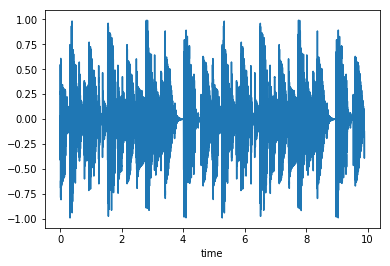

In [15]:
time_start, time_end = 0 / rate, data.size / rate

plt.plot(np.linspace(time_start, time_end, data.size), data);
plt.xlabel('time');

### Спектрограмма

(1025, 990)

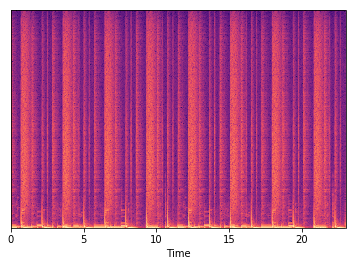

In [16]:
spectrogramm = librosa.stft(data, win_length=2048, hop_length=441)
spectrogramm = abs(spectrogramm) ** 0.05

from librosa import display
display.specshow(spectrogramm, x_axis='time');
spectrogramm.shape

### Спектрограмма с логарифмической шкалой

(128, 990)

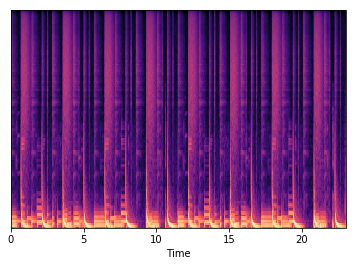

In [17]:
melspectr = librosa.feature.melspectrogram(data.astype(np.float), rate, n_fft=2048, hop_length=441)
melspectr = abs(melspectr) ** 0.05

display.specshow(melspectr, x_axis='time');
melspectr.shape

(128, 990)

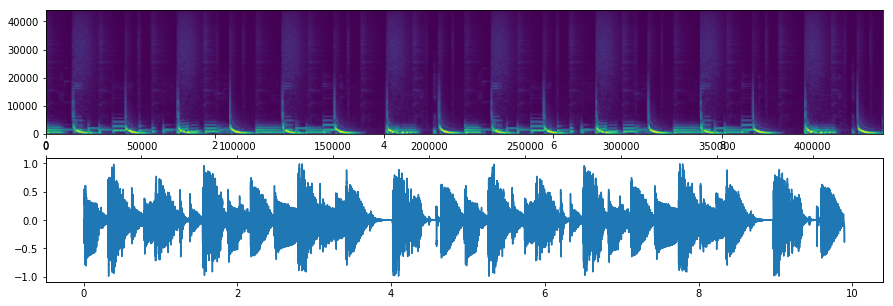

In [18]:
from librosa.feature import melspectrogram

melspectr = melspectrogram(data.astype(np.float), rate, n_fft=2048, hop_length=441)

time_start, time_end = 0 / rate, data.size / rate
fig, ax = plt.subplots(2, 1, figsize=(15,5))
im0 = ax[0].imshow(np.abs(melspectr)**0.25, origin='lower', aspect='auto', extent=[time_start, time_end, 0, rate])
im1 = ax[1].plot(np.linspace(time_start, time_end, data.size), data)
ax[1].twiny().set_xlim(0, data.size);
melspectr.shape

# Учим нейронную сеть

Дан аудио файл (1-30 секунд), определить какие классы из 80 звуков там встречаются. В одном файле может быть несколько классов.

https://www.kaggle.com/c/freesound-audio-tagging-2019

In [19]:
def open(fname):
    data, rate = librosa.load(fname, sr=44100)
    melspectr = librosa.feature.melspectrogram(data.astype(np.float), rate, n_fft=2048, hop_length=441)
    melspectr = abs(melspectr) ** 0.125
    return data, rate, melspectr


### Собака

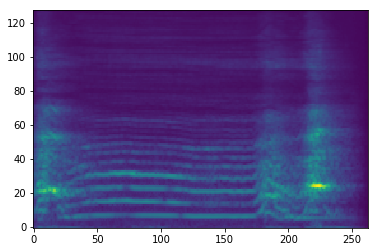

In [20]:
data, rate, melspectr = open("wav/dog.wav")
plt.imshow(melspectr, origin='lower', aspect='auto')
Audio(data=data, rate=rate)

### Гитара

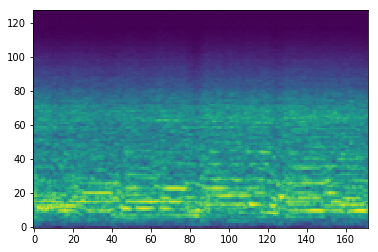

In [21]:
data, rate, melspectr = open("wav/guitar.wav")
plt.imshow(melspectr, origin='lower', aspect='auto')
Audio(data=data, rate=rate)

### Женский голос

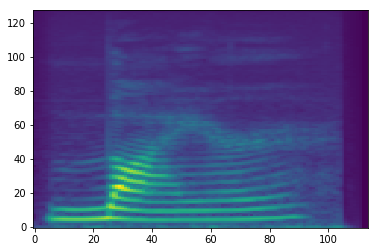

In [22]:
data, rate, melspectr = open("wav/women.wav")
plt.imshow(melspectr, origin='lower', aspect='auto')
Audio(data=data, rate=rate)

### Аккордеон

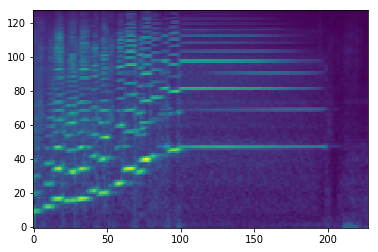

In [23]:
data, rate, melspectr = open("wav/accordean.wav")
plt.imshow(melspectr, origin='lower', aspect='auto')
Audio(data=data, rate=rate)